In [26]:
import os, sys, pickle
import numpy as np
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path = list(set(sys.path))
import matplotlib.pyplot as plt
%matplotlib inline

from results_path import DDPG_PATH, PPO_PATH

from common.evaluate import make_vis_env, test_env

from flow.multiagent_envs import MultiWaveAttenuationMergePOEnv
from flow.scenarios import MergeScenario
from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder
from ray.tune import run_experiments

import gym, ray
from ray.rllib.agents.ppo import PPOAgent, DEFAULT_CONFIG
from ray.rllib.agents.ddpg import DDPGAgent, DEFAULT_CONFIG
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print

benchmark_name = 'multi_merge'
AGENT = 'PPO' # 'PPO' or 'DDPG' or 'HUMAN'

In [27]:
# PPO_PATH = 'PPO_MultiWaveAttenuationMergePOEnv-v0_0_2019-04-18_22-06-061w6z291m'

In [28]:
print(PPO_PATH)
print(DDPG_PATH)

PPO_MultiWaveAttenuationMergePOEnv-v0_1_entropy_coeff=0.01,observation_filter=MeanStdFilter_2019-04-23_17-32-43oiiqbhe1
DDPG_MultiWaveAttenuationMergePOEnv-v0_0_actor_hiddens=[64, 64],critic_hiddens=[64, 64],lr=0.001,observation_filter=MeanStdFilter_2019-04-23_06-08-35_b17350n


In [18]:
ray.init(num_cpus=1, include_webui=False, ignore_reinit_error=True)

Calling ray.init() again after it has already been called.


In [29]:
benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.flow_params
horizon = flow_params['env'].horizon

def make_env(create_env):
    def _thunk():
        env = create_env()
        return env
    return _thunk

create_env, env_name = make_create_env(params=flow_params, version=0)

In [30]:
# Register as rllib env
register_env(env_name, create_env)

In [31]:
checkpoint = '200'
if AGENT == 'HUMAN':
    pass
else:
    if AGENT == 'PPO':
        PATH = PPO_PATH
    if AGENT == 'DDPG':
        PATH = DDPG_PATH

    config_path = '/headless/rl_project/ray_results/multi_merge/' + PATH + '/params.pkl'
    checkpoint_path = '/headless/rl_project/ray_results/multi_merge/' + PATH + '/checkpoint_{}/checkpoint-{}'.format(checkpoint, checkpoint)

    with open(config_path, mode='rb') as f:
        config = pickle.load(f)

    if AGENT == 'PPO':
        agent = PPOAgent(config=config, env=env_name)
    elif AGENT == 'DDPG':
        agent = DDPGAgent(config=config, env=env_name)
        
    agent.restore(checkpoint_path)

Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnv-v0_2019-04-23_21-49-22v3lv17z8 -> None
2019-04-23 21:49:22,823	WARNING ppo.py:137 -- By default, observations will be normalized with MeanStdFilter
 Starting SUMO on port 35991
2019-04-23 21:49:24,002	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 35991
2019-04-23 21:49:28,092	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may cons

In [32]:
# env = make_vis_env(flow_params, MultiWaveAttenuationMergePOEnv, MergeScenario)
env = create_env()

 Starting SUMO on port 51781


In [33]:
# calculate the space-time velocity map
left_length = env.k.scenario.edge_length('left')
car_length = 5.0
scale = 10

vel = []
state = env.reset()
for i in range(env.env_params.horizon):
    # record the mean velocity
    v = np.mean(env.k.vehicle.get_speed(env.k.vehicle.get_ids()))
    vel.append(v)
    
    # record the velocity map
    ids = env.k.vehicle.get_ids()
    vel_map_ = np.zeros(int(left_length)*scale)
    for id_ in ids:
        pos_ = np.round(env.k.vehicle.get_position(id_), decimals=1)
        vel_ = env.k.vehicle.get_speed(id_)
        pos_bottom = max(0, int((pos_-car_length/2.0)*scale))
        pos_top = min(int(left_length)*scale, int((pos_+car_length/2.0)*scale))
        vel_map_[pos_bottom:pos_top] = vel_            
        
    # step the simulation
    rl_ids = env.k.vehicle.get_rl_ids()
    actions = {}
    if AGENT != 'HUMAN':
        for id_ in rl_ids:
            action = agent.compute_action(state[id_])
            actions.update({id_: action})
    state, r, _, _ = env.step(actions)
    
    if i == 0:
        vel_map_list = vel_map_
    else:
        vel_map_list = np.vstack((vel_map_list, vel_map_))
        
vel_map_list[vel_map_list==0.0] = np.nan

 Starting SUMO on port 51781


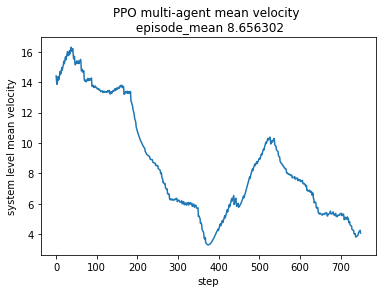

In [34]:
title = AGENT + ' multi-agent mean velocity \n episode_mean {:3f}'.format(np.mean(vel))
savepath = '../result/MultiAgent/' + title.replace(' ', '_') + '.png'

fig = plt.figure()
fig.clf()
plt.title(title)
plt.ylabel('system level mean velocity')
plt.xlabel('step')
plt.plot(vel)

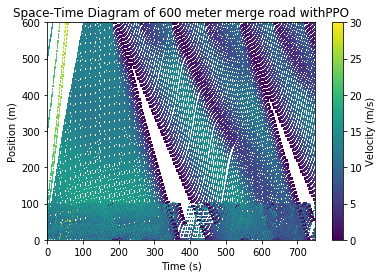

In [35]:
x = np.arange(int(env.env_params.horizon))
y = np.arange(0, int(left_length), step=0.1)
xx, yy = np.meshgrid(x, y)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
title = 'Space-Time Diagram of 600 meter merge road with' + AGENT
savepath = '../result/MultiAgent/' + title.replace(' ', '_') + '.png'
plt.title(title)
plt.pcolormesh(xx, yy, vel_map_list.T)
clb = plt.colorbar()
plt.clim(0, 30)
clb.set_label('Velocity (m/s)')

In [13]:
plt.savefig(savepath)

<Figure size 432x288 with 0 Axes>